##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

 
<img src="images/spanish-english.png" alt="spanish-english attention plot" />

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

In [42]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from shutil import rmtree

In [2]:
print('check if using GPU: ', tf.config.list_physical_devices('GPU'))
print('TF version used: ', tf.__version__)

check if using GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF version used:  2.1.0


## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [3]:
# # Download the file
# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True, cache_subdir='/tf/notebooks/')

# path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [4]:
# Saved data to disk already (cell above)
path_to_file = 'spanish-english/spanish-english-pairs.txt'

In [5]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)   # r" \1 " means keep the first subgroup returned in the re library. In our
                                         # case we only have 1 subgroup so wherever it finds what is in the parenthesis, 
                                         # it will put a space on both sides of it.
  w = re.sub(r'[" "]+', " ", w)

#   replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
en_sentence = u"May I borrow this book?"
en_sentence2 = u"May, I .borrow this book???"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(en_sentence2))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
<start> may , i . borrow this book ? ? ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    # encode, read, strip spaces at beginning and end of the string, split at new line.
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    # each English and Spanish pair is seperated by a tab (\t). This splits each pair 
    # into its respective language and preprocessed.
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    # So far it looks like this
#     [['<start> go . <end>', '<start> ve . <end>'],
#  ['<start> go . <end>', '<start> vete . <end>'],
#  ['<start> go . <end>', '<start> vaya . <end>'],
#  ['<start> go . <end>', '<start> vayase . <end>'],
#  ['<start> hi . <end>', '<start> hola . <end>'],
#  ['<start> run ! <end>', '<start> corre ! <end>'],
#  ['<start> run . <end>', '<start> corred . <end>'],
#  ['<start> who ? <end>', '<start> ¿ quien ? <end>']...]


    # Zipping allows us to separate each list in the list of lists.
    # After zipping, we will return one object that only contains English 
    # and another object that only contains the Spanish translations.
  word_pairs = zip(*word_pairs)

  return word_pairs

In [8]:
en, sp = create_dataset(path_to_file, None)
print(en[-3:])
print(sp[-3:])

('<start> a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities . some people try to reduce their carbon footprint because they are concerned about climate change . <end>', '<start> since there are usually multiple websites on any given topic , i usually just click the back button when i arrive on any webpage that has pop up advertising . i just go to the next page found by google and hope for something less irritating . <end>', '<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>')
('<start> una huella de carbono es la cantidad de contaminacion de dioxido de carbono que producimos como producto de nuestras actividades . algunas personas intentan reducir su huella de carbono porque estan preocupados acerca del cambio climatic

In [9]:
def tokenize(lang):
    
    # You can see the breakdown of this function below. Basically, it turns tokens into
    # integers. This particular notebook didn't use oov though.
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')

  lang_tokenizer.fit_on_texts(lang)

    # Turns each token to an integer.
  tensor = lang_tokenizer.texts_to_sequences(lang)

    # Pads at the end and according to the longest sequence in the list.
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [10]:
# Breakdown of the function above so you can see what it's doing.
a = en[100_090:100_093]
tokenize(a)

print(a)
_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')

_lang_tokenizer.fit_on_texts(a)

_tensor = _lang_tokenizer.texts_to_sequences(a)

print(_tensor)

tf.keras.preprocessing.sequence.pad_sequences(_tensor, padding='post')

('<start> we ll do that later when we re not so busy . <end>', '<start> we ll furnish you with everything you need . <end>', '<start> we ll furnish you with everything you need . <end>')
[[3, 1, 4, 11, 12, 13, 14, 1, 15, 16, 17, 18, 5, 6], [3, 1, 4, 7, 2, 8, 9, 2, 10, 5, 6], [3, 1, 4, 7, 2, 8, 9, 2, 10, 5, 6]]


array([[ 3,  1,  4, 11, 12, 13, 14,  1, 15, 16, 17, 18,  5,  6],
       [ 3,  1,  4,  7,  2,  8,  9,  2, 10,  5,  6,  0,  0,  0],
       [ 3,  1,  4,  7,  2,  8,  9,  2, 10,  5,  6,  0,  0,  0]],
      dtype=int32)

In [11]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [12]:
# Try experimenting with the size of that dataset
num_examples = 30_000
input_tensor, target_tensor, inp_lang_tokzer, targ_lang_tokzer = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [13]:
print(input_tensor[-5:])
print('')
print(inp_lang_tokzer)

[[   1 1184  521   14  168    3    2    0    0    0    0    0    0    0
     0    0]
 [   1 9411   45 9412    3    2    0    0    0    0    0    0    0    0
     0    0]
 [   1   18 9413   74    3    2    0    0    0    0    0    0    0    0
     0    0]
 [   1   63 2490   34  182    3    2    0    0    0    0    0    0    0
     0    0]
 [   1   23 2175   10   39   98   87  314    3    2    0    0    0    0
     0    0]]



In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang_tokzer, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang_tokzer, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> ¿
171 ----> deberia
72 ----> ir
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
123 ----> should
4 ----> i
36 ----> go
7 ----> ?
2 ----> <end>


### Create a tf.data dataset

In [17]:
# FYI: You should not use the shuffle buffer size the way this author did. If you
# had a lot of data it would be way too big of a shuffle buffer.

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang_tokzer.word_index)+1
vocab_tar_size = len(targ_lang_tokzer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))

print('Max length of input tensor (Spanish): ', example_input_batch.shape[1])
print('Max length of label tensor (English): ', example_target_batch.shape[1])

Max length of input tensor (Spanish):  16
Max length of label tensor (English):  11


## Write the encoder and decoder model

<span class="girk"> This highlighted part is written by me. The writing below is a confusing to figure out and I don't think the picture truly represents this implementation. What you need to know is that the output of the encoder is really all the hiddens states and also the last hidden state.</span>

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">
<img src="images/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

<img src="images/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="images/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output (all hidden states; hidden state for each timestep)
* H = hidden state (last hidden state)
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))` <span class="girk">My own words, creates a scalar for each timestep.</span>
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis. <span class="girk">In my own words, apply softmax to each timestep to get one attention weight per timestep. This is why you apply it to axis=1 (the timestep axis). When you do the softmax, you will have a weight for each input in the max_input_seq and doing the softmax will make the sum of all the weights = 1 which means that most inputs will probably be very low, maybe close to 0.</span>
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.  <span class="girk">In my words, this will multiply the scalar attention weight and broadcast it (multiply it by every element in the hidden state of the timestep). Since most attention weights will probably be be super low, the hidden states of the corresponding timesteps will also become super low. Then it will sum along the timestep axis so you're left with the number of hidden state units.For example, if the hidden state is 1024 at each timestep and there is a max length of 16 words then the nultiplication of this attention broadcasted multiplication will still be 16, 1024. Then the sum occurs along the timestep (sum of the columns, aka timesteps, leaving the shape of (batch_size, hidden_state_units). Just look at the code in the function to understand it if this was confusing, it will become more clear.</span>
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True, # returns all hidden states (1 for each timestep)
                    return_state=True,  # returns the last hidden state of the encoder. 
                    # We want this because we'll feed it as the hidden state for the decoder's first timestep.
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    _all_hidden_states, _last_hidden_state = self.gru(x, initial_state = hidden)
    return _all_hidden_states, _last_hidden_state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
# Initialize by feeding all zero hidden state into first timestep.
sample_hidden = encoder.initialize_hidden_state() 

# This will overwrite the initialized (all zero) hidden state from the first step with a new 
# hidden state to be passed to the next timestep.
sample_all_hidden_states, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape - all hidden states: (batch size, sequence length, hidden state units) {}'.format(sample_all_hidden_states.shape))
print ('Encoder Hidden state shape - overwritten hidden state: (batch size, hidden state units) {}'.format(sample_hidden.shape))

Encoder output shape - all hidden states: (batch size, sequence length, hidden state units) (64, 16, 1024)
Encoder Hidden state shape - overwritten hidden state: (batch size, hidden state units) (64, 1024)


In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # My own words
    # Query: Last hidden state of the encoder or decoder (batch_size, hidden units)
    # Values: All the hidden states of the encoder (batch_size, max_len_input_timesteps, hidden state units)
    
    # Add a timestep to the query so we can add it to the 'Values' (all hidden states of encoder).
    query_with_time_axis = tf.expand_dims(query, 1)

    
    ## Calculate the score.
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V (a 1 neuron linear Dense layer)
    # the shape of the tensor before applying self.V is (batch_size, max_length, hidden units)
    # My own words, hidden state units --> 1 (scalar)
    
    # Brokedown the score into 2 steps to make is easier to follow.
    # 1. Put all hidden states encoder output and last hidden state through their own
    # linear Denser layer and add them together. 
    # The hidden state, i.e. 1024 units, will be added to each
    # timestep's hidden state which also has same number of hidden units, i.e. 1024. So, the resulting shape
    # at each timestep remains, i.e. 1024 units.
    # FYI: the all hidden states outputs actually also includes the last hidden state.
    # So yes, the last hidden state output is adding to itself in the all hidden states encoder output.
    # Then then go through a tanh so the values will be between [-1, 1]
    addition_broadcast_last_hidden_to_all_hidden_states = tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values))
    # 2.Turn the hidden state into a scalar. 
    # The shape of the tensor before applying self.V (Dense layer with 1 output) 
    # is (batch_size, max_input_seq_length, units)
    # So, the final shape is (batch_size, max_input_seq_length, 1)
    score = self.V(addition_broadcast_last_hidden_to_all_hidden_states) 
    

    ## Calculate attention weights.
    # _attention_weights shape == (batch_size, max_length, 1)
    # Doing this along the timestep axis makes it so that adding each timestep sequence of the batch
    # together will be equal to 1 (I know this is true because I tried it out to make sure). 
    # This helsp the network know which timesteps, or words, to focus 
    # on because the word, timestep, from the encoder to focus on will be have higher value while 
    # the other words, timesteps, will be closer to 0 (the sum will be 1 though). 
    # The softmax is not applied to each scalar individually. That wouldn't make any sense.
    ## UNDERSTANDING APPLYING OPERATIONS TO AN AXIS!!!
    # Axis for numpy and TF is not like Pandas. Simple way to figure out what operations are being applied
    # to the axis is by doing addition on an axis. The axis in the argument will disappear in the output. 
    # For example, if you have a 2-d matrix (10, 5) and so tf.reduce_sum(axis=0) then the result is (5,) and the 
    # sum was along the columns. If you have a 3-d image (224, 224, 3) and do sum(axis=2) then the output is (224, 224) 
    # and the sum of all 3 channels at each pixel location in 2d space.
    _attention_weights = tf.nn.softmax(score, axis=1)

    
    ## Calculate context vector. 
    # 'Values' (all hidden states encoder output has shape (batch size, max_seq_length, hidden state units)).
    # _attention_weights shape == (batch_size, max_seq_length, 1)
    # There will be one scalar attention weight for each timestep in it's respective batch. 
    # This scalar will be broadcasted and multiplied on each hidden unit of that timestep. 
    # This means that words, timesteps, with high attention will be closer to 1 while
    # words that should not be focused on will be closer to 0. Doing the
    # broadcast multiplication will make the timesteps hidden units to be ignored also closer 
    # to 0 while the word to focus on will keep some of it's hidden state values because the attention
    # weight will be higher (just remember though, the sum of all the attention weights for each batch will be 1).
    _context_vector = _attention_weights * values
    # context_vector shape after the broadcasted multiplication (batch_size, max_seq_length, hidden_size)
    # Next step is to sum. Since we are summing on axis 1, that axis will disappear from the resulting matrix.
    # The final shape of the _context_vector will be (batch_size, hidden_unit). So, each hidden unit had all its
    # timesteps added together.
    _context_vector = tf.reduce_sum(_context_vector, axis=1)

    return _context_vector, _attention_weights

In [22]:
# attention_layer = BahdanauAttention(10)
# context_vectors, attention_weights = attention_layer(sample_hidden, sample_all_hidden_states)


In [23]:
attention_layer = BahdanauAttention(10)
context_vectors, attention_weights = attention_layer(sample_hidden, sample_all_hidden_states)

print("Context vectors shape: (batch size, units) {}".format(context_vectors.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Context vectors shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [24]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
#                                    return_sequences=True,  # Return all hidden states.
                                   # We don't need this for the decoder because we are just predicting.
#                                    return_state=True,  # Return last hidden state.
                                   # We don't need this either for the decoder becuase the output is already
                                   # a hidden state.
                                   recurrent_initializer='glorot_uniform')
    
    
    # There is no softmax used because the loss in later cell below has the 'from_logits' argument set to True.
    self.fc = tf.keras.layers.Dense(vocab_size) 

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, _last_hidden_state, _all_hidden_states_enc_output):
    # _all_hidden_states_enc_output shape == (batch_size, max_length, hidden_size)
    _context_vector, attention_weights = self.attention(_last_hidden_state, _all_hidden_states_enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_units)
    # _context_vector shape (batch_size, hidden_units)
    # My own words, you can think of the concat as putting 2 legos next to each other; NOT stacking them.
    x = tf.concat([tf.expand_dims(_context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU.
    # The output is only 1 hidden state because we passed in an input with 
    # only 1 timestep.
    # _hidden_state shape (batch_size, hidden_units).
    _hidden_state = self.gru(x)

    # The hidden state gets passed to fully conected layer which has the
    # same amount of neurons as the label vocab size.
    # output shape == (batch_size, vocab size)
    # There is no softmax used because the loss in a later cell below has 
    # the 'from_logits' argument set to True.
    _word_prediction = self.fc(_hidden_state)  

    return _word_prediction, _hidden_state, attention_weights



In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

_word_batch_predictions, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_all_hidden_states)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(_word_batch_predictions.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## Define the optimizer and the loss function

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # I coudln't really figure out how this works. I kinda get it but not totally.
    # The preds is a prediction at each timestep and the index with the highest value
    # will map to the predicted word. There is no softmax used because the loss object
    # has the 'from_logits' argument set to True.

    # Turns all padded zeros into False and everything else into True.
    # Real means the target label and it has shape (batch_size, max_targ_seq_length)
  mask = tf.math.not_equal(real, 0)
    
    # The loss object is a SparseCategoricalCrossentropy so the target will
    # just be an index. The predictions however in this code will not be. 
    # The predictions will be shape (batch_size, label_vocab_size)
  loss_ = loss_object(real, pred)

    # Looks like this mask will make the padded predictions into zero...IT.
    # I guess the shape of the loss is (batch_size, label_vocab_size)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The *decoder hidden state* is retained because it will be used in the next timestep for determining self attention; what words from the encoder input that the decoder input at that timestep should focus on.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [28]:
# @tf.function will created a computational graph to make things faster (the first epoch 
# is longer to build the graph).
# Since eager mode is always on in TF2, you need to comment out @tf.function
# if you need to debug because you can't do that when a computational graph is made...IT 
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    all_enc_hidden_states_output, enc_hidden = encoder(inp, enc_hidden)

    # Passing the last hidden state from the encoder to the first timestep of the decoder.
    dec_hidden = enc_hidden

    # Starting the decoder with the '<start>' token index; a index number.
    # All instances in the batch get the same index number to start decodeing to it is
    # multiplied (broadcasted) by the batch size.
    dec_input = tf.expand_dims([targ_lang_tokzer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    # Iterate through the max_seq_length of the target. In our case the input max seq length was 16
    # and the target max_seq_length is 11. So, we are interating through 11 timesteps right now.
    for t in range(1, targ.shape[1]):
      # passing all_enc_hidden_states_output to the decoder and also the last hidden state of the encoder
      # for the first step of this loop and then overwriting it.
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, all_enc_hidden_states_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing.
    # Making the next decoder input be the label instead of the prediction.
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [29]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

    # Initialize the first time step by passing a initialized (all-zero)
    # hidden state into the first encoder timestep.
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6385
Epoch 1 Batch 100 Loss 1.9920
Epoch 1 Batch 200 Loss 1.9703
Epoch 1 Batch 300 Loss 1.7427
Epoch 1 Loss 2.0496
Time taken for 1 epoch 32.93681263923645 sec

Epoch 2 Batch 0 Loss 1.6680
Epoch 2 Batch 100 Loss 1.5478
Epoch 2 Batch 200 Loss 1.3772
Epoch 2 Batch 300 Loss 1.2324
Epoch 2 Loss 1.4344
Time taken for 1 epoch 24.940255403518677 sec

Epoch 3 Batch 0 Loss 1.1873
Epoch 3 Batch 100 Loss 1.2138
Epoch 3 Batch 200 Loss 1.0442
Epoch 3 Batch 300 Loss 0.8297
Epoch 3 Loss 1.0311
Time taken for 1 epoch 24.584212064743042 sec

Epoch 4 Batch 0 Loss 0.8029
Epoch 4 Batch 100 Loss 0.7249
Epoch 4 Batch 200 Loss 0.7120
Epoch 4 Batch 300 Loss 0.6940
Epoch 4 Loss 0.7141
Time taken for 1 epoch 24.883034706115723 sec

Epoch 5 Batch 0 Loss 0.4726
Epoch 5 Batch 100 Loss 0.4755
Epoch 5 Batch 200 Loss 0.6766
Epoch 5 Batch 300 Loss 0.4716
Epoch 5 Loss 0.4955
Time taken for 1 epoch 24.73435950279236 sec

Epoch 6 Batch 0 Loss 0.4092
Epoch 6 Batch 100 Loss 0.3524
Epoch 6 Batch 200 L

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output (all hidden states).
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [30]:
def evaluate(sentence):
  _attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang_tokzer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  _prediction = ''

    # Initialize a hidden state (all zeros) to be fed into the first timestep.
  hidden = [tf.zeros((1, units))]
  enc_output_all_hidden_states, enc_last_hidden_state = encoder(inputs, hidden)

  dec_hidden = enc_last_hidden_state
  dec_input = tf.expand_dims([targ_lang_tokzer.word_index['<start>']], 0)

  for t in range(max_length_targ):
    # For each timestep in the decoder, you get back _attention_weights which is
    # the length of the max_input_length. So, for each decoder prediction 
    # (which is 1 at a time) you're getting back the attention weights which would tell 
    # you which input words were focused on for that particular decoder prediction.
    # Attention weights shape (input_max_length_seq, 1)
    predictions, dec_hidden, _attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_output_all_hidden_states)

    # storing the attention weights to plot later on.
    # The plot shape returned by this function is 
    # (11, 16) == (max_label_seq_english, max_input_seq_spanish)
    _attention_weights = tf.reshape(_attention_weights, (-1, ))
    _attention_plot[t] = _attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    
    # This is just making the predicted translation into one sequence.
    _prediction += targ_lang_tokzer.index_word[predicted_id] + ' '

    if targ_lang_tokzer.index_word[predicted_id] == '<end>':
      return _prediction, sentence, _attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return _prediction, sentence, _attention_plot

In [31]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [32]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

#   attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [33]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<span class="girk">Understanding of the attention matrix: you can think of it as the input word gets fed in, it gets provided with extra information on what context (context vector) to consider in order to predict the next word. The context vector was created from calculations which were primarily determined from the attention weights because the attention weights are a softmax that sum to 1. The important word will be closer to 1 and other words closer to 0. The attention weights multiply everything and pretty much wipe out the encoding of the hidden states, "values", which should be ignored while retaining the word to focus on because the attention weight it gets multiplied will be closer to 1. This is why you can use the attention weights to plot which word was focused on when the model decided which word to predict.</span>

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


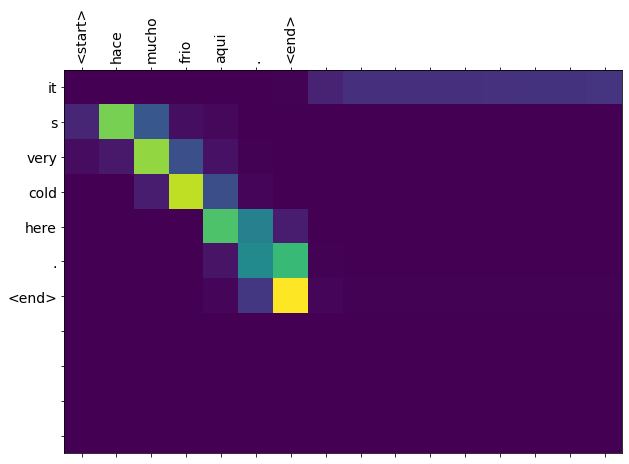

In [34]:
# This is what the plot looks like with the full attention weights matrix
# which is shape (11, 16) == (max_label_seq_leng, max_input_seq_length)
translate(u'hace mucho frio aqui.')

In [35]:
# This is what the plot looks like with the full attention weights matrix
# which is shape (11, 16) == (max_label_seq_leng, max_input_seq_length)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


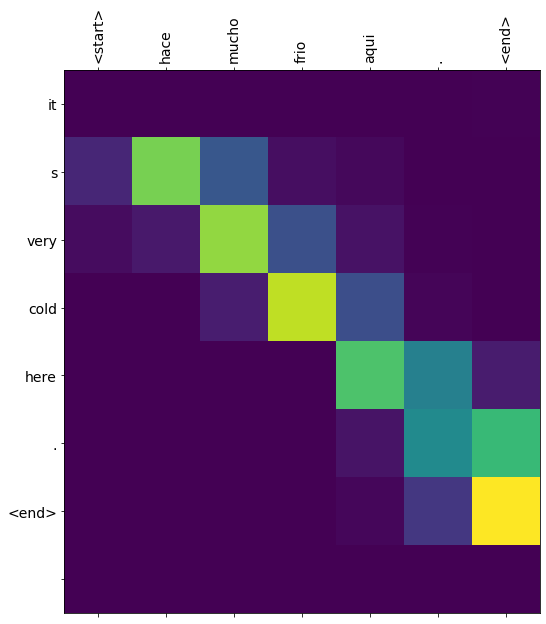

In [36]:
# This is what the plot looks like with the full attention weights matrix
# which is shape (11, 16) == (max_label_seq_leng, max_input_seq_length)
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


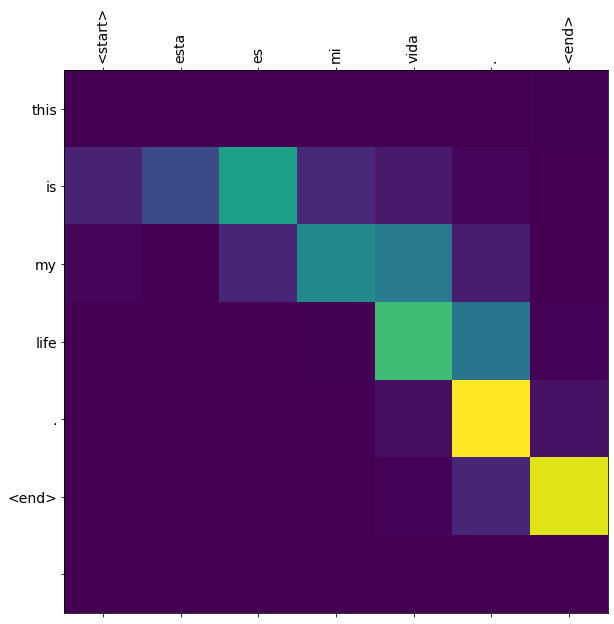

In [37]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


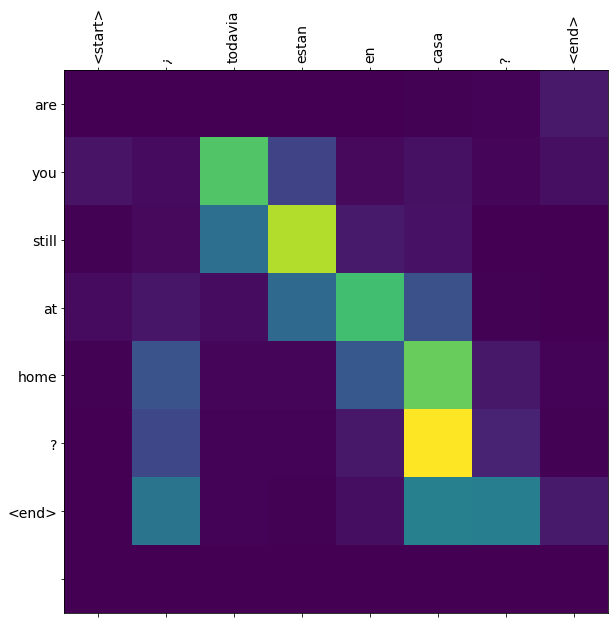

In [38]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


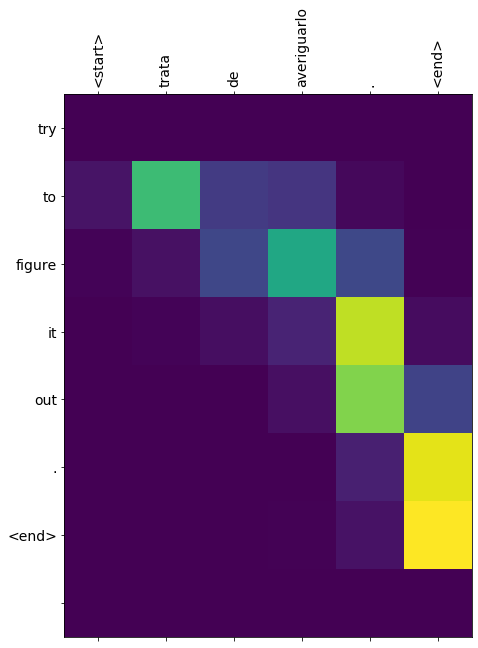

In [39]:
# wrong translation
translate(u'trata de averiguarlo.')

In [43]:
# # remove checkpoints dir
# rmtree('training_checkpoints')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
